<h1 style="text-align:center;font-size:30px;" > CNN on CIFAR-10 using Keras </h1>

Instructions:
1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 1.0 Loading & splitting the data

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
import tensorflow as tf
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoding
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 4s 0us/step


#### Prepare pixel data

In [0]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize to range 0-1
X_train  /= 255
X_test /= 255

In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

## 2.0 Utility functions

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 300
l = 6
num_filter = 35
compression = 1.0
dropout_rate = 0.2

In [0]:
# Dense Block
def denseblock(input, num_filter, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    Conv = layers.Conv2D(num_classes, (1,1),activation='softmax', use_bias=False ,padding='same')(AvgPooling)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv)
    output = layers.Flatten()(avg)
    return output

## 3.0 Data Augmentation

In [0]:
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

import warnings
warnings.filterwarnings("ignore")

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                             rotation_range=50,fill_mode='nearest',zoom_range=0.10)
# prepare iterator
it_train = datagen.flow(X_train,y_train, batch_size=batch_size)

## 4.0 Architecture & compile model

In [0]:
import warnings
warnings.filterwarnings("ignore")

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [23]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 32, 32, 35)   945         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 32, 32, 35)   140         conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 32, 32, 35)   0           batch_normalization_56[0][0]     
____________________________________________________________________________________________

In [0]:
# Loading the checkpoints if required
model.load_weights("/content/model-ep107-val_loss0.327.h5")

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

## 5.0 Checkpointing the model

In [0]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt

filepath = 'model-ep{epoch:03d}-val_loss{val_loss:.3f}.h5'
checkpoints = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
train_results = CSVLogger('train_results.log') #storing the training results in a pandas dataframe
callbacks_list = [checkpoints, train_results]

## 6.0 Fitting the model in batches

In [27]:
steps = int(X_train.shape[0] / batch_size)
history = model.fit_generator(it_train,steps_per_epoch=steps,epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list )

Epoch 1/190
10000/781 [================================================================================================================================================================================================================================================================================================================================================================================================] - 4s 395us/sample - loss: 0.3820 - acc: 0.8761

Epoch 00001: val_loss improved from inf to 0.42766, saving model to model-ep001-val_loss0.428.h5
781/781 [==============================] - 86s 110ms/step - loss: 0.2736 - acc: 0.9056 - val_loss: 0.4277 - val_acc: 0.8761
Epoch 2/190
10000/781 [===========================================================================================================================================================================================================================================================================================================

In [28]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


## 7.0 Plots on training results

In [0]:
# function to plot epoch vs loss
%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot
def plot(history):
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.xlabel('Epoch')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(122)
    pyplot.title('\nClassification Accuracy')
    pyplot.xlabel('Epoch')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')

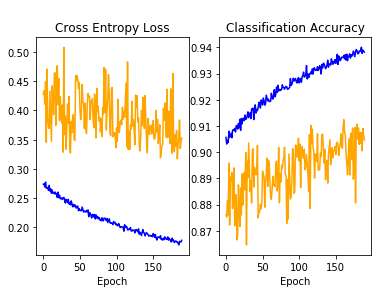

In [30]:
plot(history)

## 8.0 Model Testing

In [31]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 319us/sample - loss: 0.3540 - acc: 0.9047
Test loss: 0.3539511471837759
Test accuracy: 0.9047
